In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys
import re

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests11 as vuong_tests_fast

In [2]:
class OLS_loglike(GenericLikelihoodModel):
    
    def __init__(self, *args,ols=False, **kwargs):
        super(OLS_loglike,self).__init__(*args,**kwargs)
        self.ols = ols

    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        mu_y = np.matmul(x,params)  
        resid = y - mu_y
        sigma = np.sqrt(np.sum(resid**2)/resid.shape[0])
        pr_y = stats.norm.logpdf( resid, loc=0,scale=sigma )
        return pr_y


def setup_shi(yn,xn,return_model=False,num_params=9):
    x1n,x2n = xn[:,0],xn[:,1:num_params+1]
    
    # model 1 grad, etc.
    model1 = sm.OLS(yn,sm.add_constant(x1n))
    model1_fit = model1.fit(disp=False)
    params1 = (model1_fit.params)
    
    model1_deriv = OLS_loglike(yn,sm.add_constant(x1n))
    ll1 = model1_deriv.loglikeobs(model1_fit.params)
    grad1 =  model1_deriv.score_obs(model1_fit.params)    
    hess1 = model1_deriv.hessian(model1_fit.params)
    
    #model 2 grad, etc.
    model2 = sm.OLS(yn,sm.add_constant(x2n))
    model2_fit = model2.fit(disp=False)
    params2 = (model2_fit.params)
    
    model2_deriv = OLS_loglike(yn,sm.add_constant(x2n))
    ll2 = model2_deriv.loglikeobs(model2_fit.params)
    grad2 =  model2_deriv.score_obs(model2_fit.params)    
    hess2 = model2_deriv.hessian(model2_fit.params)
    
    if return_model:
        return ll1,grad1,hess1,params1,model1,ll2,grad2,hess2,params2,model2
    return ll1,grad1,hess1,params1,ll2,grad2,hess2,params2


In [3]:
def gen_data(nobs=1000, a=0.25, num_params=9):
    x = np.random.normal(scale=1., size=(nobs,1+num_params))
    e = np.random.normal(loc=0.0, scale=1.0, size=nobs)
    y = 1 + a*x[:,0] + a/np.sqrt(num_params)*x[:,1:num_params+1].sum(axis=1) + e
    return y,x,nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn,return_model=False,num_params=9)
print(grad1.shape,hess1.shape)

(1000, 2) (2, 2)


In [4]:

nsims= 700
trials =1000
skip_boot=False
skip_shi=False
linspace= 40
smoothing =5
adapt_c= True
data_tuned_epsilon = True
biascorrect = True

In [5]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'SW Test','Shi (2015)', 'Naive Bootstrap','Pairwise Bootstrap',
                  'Optimal SW Test','Optimal Pairwise Bootstrap']


    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs_0928/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    plt.plot(params_new, interp(1-results2[:,2,0]) ,label='SW Test')
    
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,5,0]),label='Pairwise Bootstrap')
        
    if data_tuned_epsilon:
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Optimal SW Test')
        plt.plot(params_new,interp(1-results2[:,7,0]),label='Optimal Pairwise Bootstrap')
        


    plt.legend()
    plt.savefig('paper_figs_0928/'+name,dpi=300)
    plt.show()


In [6]:
def keep_alphanumeric(string):
    return re.sub(r'[^a-zA-Z0-9_]', '', string)


def mc_run_size(nobs,epsilon,data_tuned_epsilon=None):
    betas = np.linspace(0,3,linspace)
    results = []
    for beta in betas:
        setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=9)
        gen_data_ex = lambda : gen_data(nobs=nobs, a =beta,num_params=9)
        mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                              skip_boot=skip_boot,skip_shi=skip_shi,
                                              epsilon=epsilon,data_tuned_epsilon=data_tuned_epsilon,biascorrect=biascorrect)
        reg,twostep, sw, boot1,boot2,sw_test_opt,boot3,shi, llr,std, omega = mc_out
        results.append([reg,twostep,sw,shi,boot1,boot2,sw_test_opt,boot3])

        print(beta,boot2)

    name = keep_alphanumeric('sw_table_d_biascorrect_size_c1%s_datac%s_nobs%s_trials%s'%(epsilon,data_tuned_epsilon,nobs,trials))
    name = name+'.png'
    print('--------saving fig------------')
    print(name)
    print('--------------------')
    create_fig(betas,results,name=name)

0.0 [0.94285714 0.05714286 0.        ]
0.07692307692307693 [0.94714286 0.05142857 0.00142857]
0.15384615384615385 [0.94857143 0.05       0.00142857]
0.23076923076923078 [0.93857143 0.06       0.00142857]
0.3076923076923077 [0.96285714 0.03428571 0.00285714]
0.38461538461538464 [0.95       0.04142857 0.00857143]
0.46153846153846156 [0.96285714 0.03       0.00714286]
0.5384615384615385 [0.95142857 0.03571429 0.01285714]
0.6153846153846154 [0.95857143 0.03428571 0.00714286]
0.6923076923076923 [0.96285714 0.03285714 0.00428571]
0.7692307692307693 [0.94857143 0.03285714 0.01857143]
0.8461538461538463 [0.94       0.04714286 0.01285714]
0.9230769230769231 [0.95714286 0.02571429 0.01714286]
1.0 [0.95428571 0.03428571 0.01142857]
1.076923076923077 [0.96428571 0.03       0.00571429]
1.153846153846154 [0.94285714 0.04142857 0.01571429]
1.2307692307692308 [0.95       0.02714286 0.02285714]
1.3076923076923077 [0.95857143 0.03285714 0.00857143]
1.3846153846153846 [0.95714286 0.03       0.01285714]
1

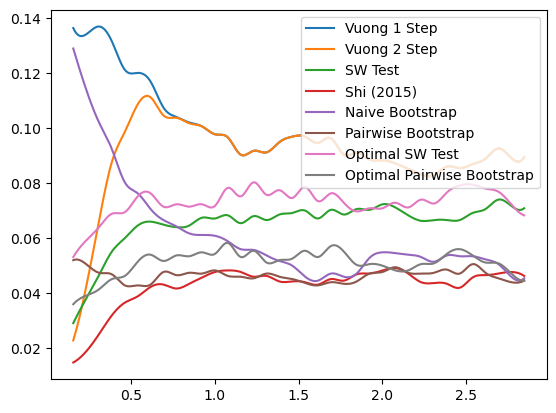

In [7]:
epsilon=.5
nobs=100

mc_run_size(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon)

0.0 [0.96       0.03714286 0.00285714]
0.07692307692307693 [0.96857143 0.03       0.00142857]
0.15384615384615385 [0.97285714 0.02571429 0.00142857]
0.23076923076923078 [0.94       0.04714286 0.01285714]
0.3076923076923077 [0.96       0.02571429 0.01428571]
0.38461538461538464 [0.96571429 0.02714286 0.00714286]
0.46153846153846156 [0.96714286 0.02428571 0.00857143]
0.5384615384615385 [0.96142857 0.02571429 0.01285714]
0.6153846153846154 [0.96142857 0.03142857 0.00714286]
0.6923076923076923 [0.96714286 0.02571429 0.00714286]
0.7692307692307693 [0.95857143 0.02714286 0.01428571]
0.8461538461538463 [0.95857143 0.02857143 0.01285714]
0.9230769230769231 [0.96857143 0.01857143 0.01285714]
1.0 [0.96285714 0.02857143 0.00857143]
1.076923076923077 [0.97428571 0.01571429 0.01      ]
1.153846153846154 [0.96571429 0.02428571 0.01      ]
1.2307692307692308 [0.97428571 0.01714286 0.00857143]
1.3076923076923077 [0.96142857 0.03       0.00857143]
1.3846153846153846 [0.97142857 0.02       0.00857143]
1

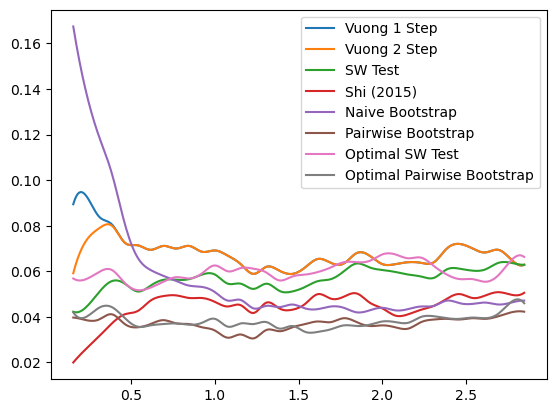

In [8]:
epsilon=.5
nobs=250

mc_run_size(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon)

0.0 [0.96714286 0.03       0.00285714]
0.07692307692307693 [0.95714286 0.04       0.00285714]
0.15384615384615385 [0.96571429 0.02714286 0.00714286]
0.23076923076923078 [0.96571429 0.02428571 0.01      ]
0.3076923076923077 [0.97 0.02 0.01]
0.38461538461538464 [0.97571429 0.01714286 0.00714286]
0.46153846153846156 [0.95571429 0.03428571 0.01      ]
0.5384615384615385 [0.97428571 0.02142857 0.00428571]
0.6153846153846154 [0.96714286 0.02142857 0.01142857]
0.6923076923076923 [0.96       0.02571429 0.01428571]
0.7692307692307693 [0.96714286 0.01857143 0.01428571]
0.8461538461538463 [0.96714286 0.01714286 0.01571429]
0.9230769230769231 [0.97857143 0.01428571 0.00714286]
1.0 [0.98142857 0.01285714 0.00571429]
1.076923076923077 [0.97857143 0.01285714 0.00857143]
1.153846153846154 [0.96285714 0.02285714 0.01428571]
1.2307692307692308 [0.96857143 0.02       0.01142857]
1.3076923076923077 [0.96571429 0.02       0.01428571]
1.3846153846153846 [0.97       0.01857143 0.01142857]
1.4615384615384617 

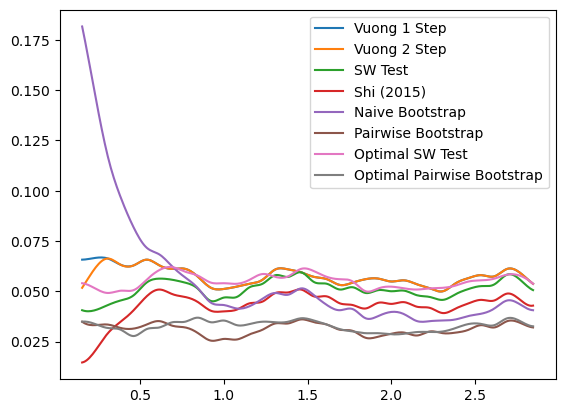

In [9]:
epsilon=.5
nobs=500

mc_run_size(nobs,epsilon,data_tuned_epsilon=data_tuned_epsilon)